<a href="https://colab.research.google.com/github/parvez018/pytorchviz/blob/master/spinodal_decomp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-zkr4_633
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-zkr4_633
  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4970 sha256=3cd5f0fee25f16d067b01914a64baa62474a5e970dc51abb3e85223251b2d58d
  Stored in directory: /tmp/pip-ephem-wheel-cache-61o8texx/wheels/fc/d6/e6/66dc628cd51f1839234ed28feeba942a6f68bc69cec3b8f137
Successfully built torchviz


### Spinodal decomposiotion Pytorch default

In [4]:
class LaplacianOp(nn.Module):
	def __init__(self):
		super(LaplacianOp, self).__init__()
		# self.conv_kernel = nn.Parameter(torch.tensor([[[[0,1,0],[1,-4,1],[0,1,0]]]], dtype=torch.float),
		                                # requires_grad=False)
		
		self.conv_kernel = torch.tensor([[[[0,1,0],[1,-4,1],[0,1,0]]]],\
										dtype=torch.float).to(device)


	def forward(self, inputs, dx=1.0, dy=1.0):
		'''
		:param inputs: [batch, iH, iW], torch.float
		:return: laplacian of inputs
		'''
		unsqueezed = False
		# print("inside diff_ops, inputs = ",inputs.size())
		if inputs.dim() == 2:
			inputs = torch.unsqueeze(inputs, 0)
			unsqueezed = True
		inputs1 = torch.cat([inputs[:, -1:, :], inputs, inputs[:, :1, :]], dim=1)
		inputs2 = torch.cat([inputs1[:, :, -1:], inputs1, inputs1[:, :, :1]], dim=2)
		conv_inputs = torch.unsqueeze(inputs2, dim=1).to(device)
		result = torch.nn.functional.conv2d(input=conv_inputs, weight=self.conv_kernel).squeeze(dim=1) / (dx*dy)
		if unsqueezed:
			result = torch.squeeze(result, 0)
		'''
		# dimension of result? same as inputs argument?
		'''
		return result

In [33]:
MIN_CON,MAX_CON = 0.0001,0.9999

In [35]:
def fix_deviations(mat, lb=0.0, ub=1.0):
    clipped_low = torch.count_nonzero(con<lb)
    clipped_high = torch.count_nonzero(con>=ub)
    print("low,high,total",clipped_low,clipped_high,clipped_low+clipped_high)
    mat.masked_fill_(torch.ge(mat, ub).detach(), ub)
    mat.masked_fill_(torch.le(mat, lb).detach(), lb)
    return mat

class SpinDecompSingleTimestep(nn.Module):
    def __init__(self,dtime=1e-4,dx=1.0,dy=1.0,filter_mode='wrap'):
        super(SpinDecompSingleTimestep, self).__init__()

        self.mobility = nn.Parameter(torch.tensor(5.0), requires_grad=True) 
        self.kappa = nn.Parameter(torch.tensor(5.0), requires_grad=True) 

        self.dtime = dtime
        self.dx = dx
        self.dy = dy
        self.lap = LaplacianOp()

        self.initial_params = {'kappa':self.kappa.data,'mobility':self.mobility.data}
    
    def init_params(self,kappa,mobility):
        self.kappa.data = torch.tensor(kappa)
        self.mobility.data = torch.tensor(mobility)

        print("Set params to",self.kappa,self.mobility)
    



    def free_energy(self,con):
        dfdcon = 2.0*con*(1-con)*(1-2*con)
        return dfdcon


    def forward(self,con):
        lap_con = self.lap(con,dx=self.dx,dy=self.dy)
        mu = self.free_energy(con)
        lap_lap_con = self.lap(lap_con,dx=self.dx,dy=self.dy)
        lap_mu = self.lap(mu,dx=self.dx,dy=self.dy)
        lap_dF_dc = lap_mu - self.kappa*lap_lap_con
        updates = self.dtime*self.mobility*lap_dF_dc

        con_new = con + updates
        fix_deviations(con_new)
        
        return con_new

## Training

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
model = SpinDecompSingleTimestep().to(device)

In [38]:
Nx,Ny = 32,32
c0 = 0.5
con1 = None
con2 = None
model.init_params(0.6,0.9)
with torch.no_grad():
  con1 = torch.zeros(Nx,Ny,dtype=torch.float)
  con1[int(Nx/4):int(3*Nx/4),int(Nx/4):int(3*Nx/4)] = c0
  con2 = model(con1)

Set params to Parameter containing:
tensor(0.6000, requires_grad=True) Parameter containing:
tensor(0.9000, requires_grad=True)
low,high,total tensor(0) tensor(0) tensor(0)


In [39]:
learning_rate = 0.02
dc_model = SpinDecompSingleTimestep().to(device)
optimizer = torch.optim.Adam(dc_model.parameters(), lr=learning_rate)
mse = nn.MSELoss(reduction='sum').to(device)
skip_step = 1

In [40]:
ncon2 = dc_model(con1)

low,high,total tensor(0) tensor(0) tensor(0)


low,high,total tensor(0) tensor(0) tensor(0)


/usr/local/lib/python3.7/dist-packages/torchviz/dot.py:68: UserWarning: make_dot: showing grad_fn attributes and saved variables requires PyTorch version >= 1.9. (This does NOT apply to saved tensors saved by custom autograd functions.)
  "make_dot: showing grad_fn attributes and saved variables"


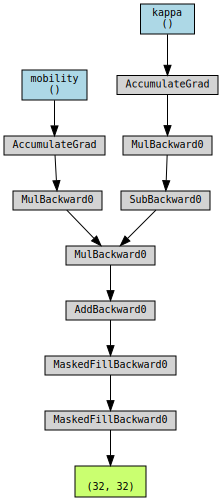

In [42]:
make_dot(dc_model(con1), params=dict(dc_model.named_parameters()), show_attrs = True)

In [44]:
batch_loss = mse(con2,ncon2)

In [45]:
optimizer.zero_grad()
batch_loss.backward()

In [46]:
print("Final gradients")
for name,param in dc_model.named_parameters():
    print(name,"gradient:=",param.grad)

Final gradients
mobility gradient:= tensor(0.0009)
kappa gradient:= tensor(0.0009)


### Spinodal Decomp Autograd

In [48]:
class SpinDecompSingleTimestepAg(torch.autograd.Function):
    @staticmethod
    def forward(ctx,input,kappa,mobility,free_energy_func,lap_func,dtime,dx,dy):
        lap_con = lap_func(input,dx=dx,dy=dy)
        mu = free_energy_func(input)
        lap_lap_con = lap_func(lap_con,dx=dx,dy=dy)
        lap_mu = lap_func(mu,dx=dx,dy=dy)
        lap_dF_dc = lap_mu - kappa*lap_lap_con
        updates = dtime*mobility*lap_dF_dc

        con_new = input + updates
        fix_deviations(con_new)
        ctx.save_for_backward(input,mobility,kappa)
        ctx.lap_func = lap_func
        ctx.free_energy_func = free_energy_func
        ctx.dtime = dtime
        ctx.dx = dx
        ctx.dy = dy

        return con_new

    @staticmethod
    def backward(ctx,grad_output):
        input,mobility,kappa = ctx.saved_tensors
        dx = ctx.dx
        dy = ctx.dy
        dtime = ctx.dtime
        lap_func = ctx.lap_func
        free_energy_func = ctx.free_energy_func
        
        lap_con = lap_func(input,dx=dx,dy=dy)
        mu = free_energy_func(input)
        lap_lap_con = lap_func(lap_con,dx=dx,dy=dy)
        lap_mu = lap_func(mu,dx=dx,dy=dy)
        lap_dF_dc = lap_mu - kappa*lap_lap_con

        grad_M = lap_dF_dc*dtime
        grad_kappa = -1.0*dtime*mobility*lap_lap_con

        dloss_dG = ctx.lap_func(grad_output,dx=dx,dy=dy)*dtime*mobility
        dmu_dc = 12*(input**2)-12*(input)+2
        lap_dloss_dG = ctx.lap_func(dloss_dG,dx=dx,dy=dy)

        grad_c = grad_output
        grad_c += dloss_dG*dmu_dc
        grad_c += -1.0*kappa*lap_dloss_dG
        return grad_c,grad_output*grad_kappa,grad_output*grad_M,None,None,None,None,None


class WrappedSpinDecompSingleTimestep(nn.Module):
    def __init__(self,dtime=1e-4,dx=1.0,dy=1.0,filter_mode='wrap'):
        super(WrappedSpinDecompSingleTimestep, self).__init__()

        self.mobility = nn.Parameter(torch.tensor(5.0), requires_grad=True) 
        self.kappa = nn.Parameter(torch.tensor(5.0), requires_grad=True) 

        self.dtime = dtime
        self.dx = dx
        self.dy = dy
        self.lap = LaplacianOp()

        self.initial_params = {'kappa':self.kappa.clone().data.numpy(),
                                'mobility':self.mobility.clone().data.numpy()}
    

    def init_params(self,kappa,mobility):
        self.kappa.data = torch.tensor(kappa)
        self.mobility.data = torch.tensor(mobility)

        print("Set params to",self.kappa,self.mobility)
    
    def print_params(self):
        print("dtime %f, dx %f dy %f kappa %f mobility %f"%(self.dtime,self.dx,self.dy,self.kappa,self.mobility))



    def free_energy(self,con):
        dfdcon = 2.0*con*(1-con)*(1-2*con)
        return dfdcon


    def forward(self,con):
        con_new = SpinDecompSingleTimestepAg.apply(con,self.kappa,self.mobility,self.free_energy,self.lap,self.dtime,self.dx,self.dy)
        
        return con_new

In [62]:
wdc_model = WrappedSpinDecompSingleTimestep().to(device)
wdc_model.print_params()
woptimizer = torch.optim.Adam(dc_model.parameters(), lr=learning_rate)
wmse = nn.MSELoss(reduction='sum').to(device)

dtime 0.000100, dx 1.000000 dy 1.000000 kappa 5.000000 mobility 5.000000


low,high,total tensor(0) tensor(0) tensor(0)


/usr/local/lib/python3.7/dist-packages/torchviz/dot.py:68: UserWarning: make_dot: showing grad_fn attributes and saved variables requires PyTorch version >= 1.9. (This does NOT apply to saved tensors saved by custom autograd functions.)
  "make_dot: showing grad_fn attributes and saved variables"


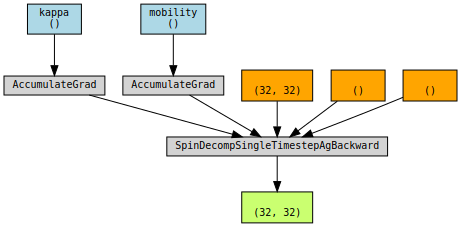

In [50]:
make_dot(wdc_model(con1), params=dict(wdc_model.named_parameters()), show_attrs = True)

In [63]:
wcon2 = wdc_model(con1)
wloss = mse(wcon2,con2)
woptimizer.zero_grad()
wloss.backward()

low,high,total tensor(0) tensor(0) tensor(0)


In [64]:
for name,param in wdc_model.named_parameters():
    print(name,"value",param.data,"gradient:=",param.grad)

mobility value tensor(5.) gradient:= tensor(0.0009)
kappa value tensor(5.) gradient:= tensor(0.0009)
